# K-SVD

In [43]:
import numpy as np
from skimage.util.shape import *
from operator import mul, sub
from math import floor, sqrt, log10
import sys
from scipy.sparse.linalg import svds
from scipy.stats import chi2
from skimage.util import pad
import timeit
from matplotlib import pyplot as plt

def patch_matrix_windows(img, window_shape, step):
    patches = view_as_windows(img, window_shape, step=step)
    cond_patches = np.zeros((reduce(mul, patches.shape[2:4]), reduce(mul, patches.shape[0:2])))
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            cond_patches[:, j+patches.shape[1]*i] = np.concatenate(patches[i, j], axis=0)
    return cond_patches, patches.shape


def image_reconstruction_windows(mat_shape, patch_mat, patch_sizes, step):
    img_out = np.zeros(mat_shape)
    for l in range(patch_mat.shape[1]):
        i, j = divmod(l, patch_sizes[1])
        temp_patch = patch_mat[:, l].reshape((patch_sizes[2], patch_sizes[3]))
        img_out[i*step:(i+1)*step, j*step:(j+1)*step] = temp_patch[:step, :step].astype(int)
    return img_out


#-------------------------------------------------------------------------------------------------------------------#
#------------------------------------------ APPROXIMATION PURSUIT METHOD : -----------------------------------------#
#------------------------------------- MULTI-CHANNEL ORTHOGONAL MATCHING PURSUIT -----------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

def single_channel_omp(phi, vect_y, sigma):

    vect_sparse = np.zeros(phi.shape[1])
    res = np.linalg.norm(vect_y)
    atoms_list = []

    while res/sigma > sqrt(chi2.ppf(0.995, vect_y.shape[0] - 1)) \
            and len(atoms_list) < phi.shape[1]:
        vect_c = phi.T.dot(vect_y - phi.dot(vect_sparse))
        i_0 = np.argmax(np.abs(vect_c))
        atoms_list.append(i_0)
        vect_sparse[i_0] += vect_c[i_0]

        # Orthogonal projection.
        index = np.where(vect_sparse)[0]
        vect_sparse[index] = np.linalg.pinv(phi[:, index]).dot(vect_y)
        res = np.linalg.norm(vect_y - phi.dot(vect_sparse))

    return vect_sparse, atoms_list


def cholesky_omp(phi, vect_y, sigma):

    vect_sparse = np.zeros(phi.shape[1])
    atoms_list = []
    vect_alpha = phi.T.dot(vect_y)
    res = vect_y
    l = np.ones((1, 1))
    count = 1

    while np.linalg.norm(res)/sigma > sqrt(chi2.ppf(0.995, vect_y.shape[0] - 1)) \
            and len(atoms_list) < vect_sparse.shape[0]:

        c = phi.T.dot(res)
        i_0 = np.argmax(np.abs(c))

        if count > 1:
            w = np.linalg.solve(l, phi[:, atoms_list].T.dot(phi[:, i_0]))
            l = np.insert(l, l.shape[1], 0, axis=1)
            l = np.insert(l, l.shape[0], np.append(w.T, sqrt(1 - np.linalg.norm(w))), axis=0)

        atoms_list.append(i_0)
        vect_sparse[atoms_list] = np.linalg.solve(l.dot(l.T), vect_alpha[atoms_list])
        res = vect_y - phi[:, atoms_list].dot(vect_sparse[atoms_list])
        count += 1

    return vect_sparse, atoms_list


def batch_omp(phi, vect_y, sigma):

    #Initial values
    vect_alpha = phi.T.dot(vect_y)
    epsilon = pow(np.linalg.norm(vect_y), 2)
    matrix_g = phi.T.dot(phi)

    atoms_list = []
    l = np.ones((1, 1))
    vect_sparse = np.zeros(phi.shape[1])
    delta = 0
    count = 1

    while np.linalg.norm(epsilon)/sigma > sqrt(chi2.ppf(0.995, vect_y.shape[0] - 1)) \
            and len(atoms_list) < phi.shape[1]:
        i_0 = np.argmax(np.abs(vect_alpha))

        if count > 1:
            w = np.linalg.solve(l, phi.T[atoms_list].dot(phi[:, i_0]))
            l = np.insert(l, l.shape[0], 0, axis=0)
            l = np.insert(l, l.shape[1], 0, axis=1)
            l[-1, :] = np.append(w.T, sqrt(1 - np.linalg.norm(w)))

        atoms_list.append(i_0)
        vect_sparse[atoms_list] = np.linalg.solve(l.dot(l.T), vect_alpha[atoms_list])
        vect_beta = matrix_g[:, atoms_list].dot(vect_sparse[atoms_list])
        vect_alpha = phi.T.dot(vect_y) - vect_beta
        epsilon += - vect_sparse[atoms_list].T.dot(vect_beta[atoms_list]) + delta
        delta = vect_sparse[atoms_list].T.dot(vect_beta[atoms_list])
        count += 1

    return vect_sparse, atoms_list


#-------------------------------------------------------------------------------------------------------------------#
#------------------------------------------- DICTIONARY UPDATING METHODS -------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#


def dict_update(phi, matrix_y, matrix_sparse, k):
    indexes = np.where(matrix_sparse[k, :]!=0)[0]
    phi_temp = phi
    sparse_temp = matrix_sparse

    if len(indexes) > 0:
        phi_temp[:, k][:] = 0

        matrix_e_k = matrix_y[:, indexes] - phi_temp.dot(sparse_temp[:, indexes])
        u, s, v = svds(np.atleast_2d(matrix_e_k), 1)

        phi_temp[:, k] = u[:, 0]
        sparse_temp[k, indexes] = np.asarray(v)[0] * s[0]
    return phi_temp, sparse_temp


def approx_update(phi, matrix_y, matrix_sparse, k):
    indexes = np.where(matrix_sparse[k, :] != 0)[0]
    phi_temp = phi

    if len(indexes) > 0:
        phi_temp[:, k] = 0
        vect_g = matrix_sparse[k, indexes].T
        vect_d = (matrix_y - phi_temp.dot(matrix_sparse))[:, indexes].dot(vect_g)
        vect_d /= np.linalg.norm(vect_d)
        vect_g = (matrix_y - phi_temp.dot(matrix_sparse))[:, indexes].T.dot(vect_d)
        phi_temp[:, k] = vect_d
        matrix_sparse[k, indexes] = vect_g.T
    return phi_temp, matrix_sparse


#-------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------- K-SVD ALGORITHM -------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

def k_svd(phi, matrix_y, sigma, algorithm, n_iter, approx='yes'):
    phi_temp = phi
    matrix_sparse = np.zeros((phi.T.dot(matrix_y)).shape)
    n_total = []
    
    print('matrix_sparse.shape: ', matrix_sparse.shape)

    print ('\nK-SVD, with residual criterion.')
    print ('-------------------------------')

    for k in range(n_iter):
        print ("Stage " + str(k+1) + "/" + str(n_iter) + "...")
 
        def sparse_coding(f):
            t = f+1
            sys.stdout.write("\r- Sparse coding : Channel %d" % t)
            sys.stdout.flush()
            return algorithm(phi_temp, matrix_y[:, f], sigma)[0]
 
        sparse_rep = list(map(sparse_coding, range(matrix_y.shape[1])))
        matrix_sparse = np.array(sparse_rep).T

        count = 1
        updating_range = phi.shape[1]
        print ('updating range: ', updating_range)
        for j in range(updating_range):
            r = floor(count/float(updating_range)*100)
            sys.stdout.write("\r- Dictionary updating : %d%%" % r)
            sys.stdout.flush()
            if approx == 'yes':
                phi_temp, matrix_sparse = approx_update(phi_temp, matrix_y, matrix_sparse, j)
            else:
                phi_temp, matrix_sparse = dict_update(phi_temp, matrix_y, matrix_sparse, j)
            count += 1
        print ('\r- Dictionary updating complete.\n')

    return phi_temp, matrix_sparse, n_total


#-------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------ DENOISING METHOD -------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

def denoising(noisy_image, learning_image, window_shape, window_step, sigma, learning_ratio=0.1, ksvd_iter=1):

    # 1. Form noisy patches.
    padded_noisy_image = pad(noisy_image, pad_width=window_shape, mode='symmetric')
    noisy_patches, noisy_patches_shape = patch_matrix_windows(padded_noisy_image, window_shape, window_step)
    padded_lea_image = pad(learning_image, pad_width=window_shape, mode='symmetric')
    lea_patches, lea_patches_shape = patch_matrix_windows(padded_lea_image, window_shape, window_step)
    print ('Shape of dataset    : ' + str(noisy_patches.shape))

    # 2. Form explanatory dictionary.
    k = int(learning_ratio*lea_patches.shape[1])
    indexes = np.random.random_integers(0, lea_patches.shape[1]-1, k)

    basis = lea_patches[:, indexes]
    basis /= np.sum(basis.T.dot(basis), axis=-1)

    print ('Shape of dictionary : ' + str(basis.shape) + '\n')

    # 3. Compute K-SVD.
    start = timeit.default_timer()
    basis_final, sparse_final, n_total = k_svd(basis, noisy_patches, sigma, single_channel_omp, ksvd_iter)
    stop = timeit.default_timer()
    print ("Calculation time : " + str(stop - start) + ' seconds.')

    # 4. Reconstruct the image.
    patches_approx = basis_final.dot(sparse_final)
    padded_denoised_image = image_reconstruction_windows(padded_noisy_image.shape,
                                                         patches_approx, noisy_patches_shape, window_step)
    shrunk_0, shrunk_1 = tuple(map(sub, padded_denoised_image.shape, window_shape))
    denoised_image = np.abs(padded_denoised_image)[window_shape[0]:shrunk_0, window_shape[1]:shrunk_1]
    return denoised_image, stop - start, n_total

Shape of dataset    : (256, 1156)
Shape of dictionary : (256, 1156)

matrix_sparse.shape:  (1156, 1156)

K-SVD, with residual criterion.
-------------------------------
Stage 1/5...
- Sparse coding : Channel 1

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: DeprecationWarning: This function is deprecated. Please call randint(0, 1155 + 1) instead


- Sparse coding : Channel 1156updating range:  1156
- Dictionary updating complete.

Stage 2/5...
- Sparse coding : Channel 1156updating range:  1156
- Dictionary updating complete.

Stage 3/5...
- Sparse coding : Channel 1156updating range:  1156
- Dictionary updating complete.

Stage 4/5...
- Sparse coding : Channel 1156updating range:  1156
- Dictionary updating complete.

Stage 5/5...
- Sparse coding : Channel 1156updating range:  1156
- Dictionary updating complete.

Calculation time : 143.5628713000001 seconds.


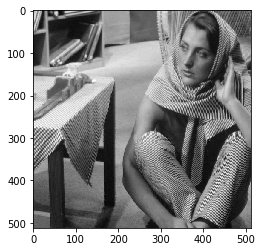

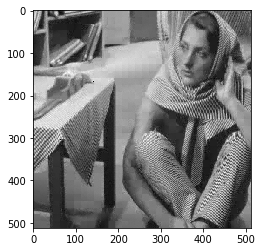

In [44]:
from PIL import Image
from imageio import imwrite as imsave
from functools import reduce

#-------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------- 1. Initial settings. -------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

resize_shape = (512, 512) # Resized image's shape
sigma = 10                 # Noise standard dev.

window_shape = (16, 16)   # Patches' shape
step = 16                  # Patches' step
ratio = 1             # Ratio for the dictionary (training set).
ksvd_iter = 5              # Number of iterations for the K-SVD.

#-------------------------------------------------------------------------------------------------------------------#
#--------------------------------------------------- 2. Image import. ----------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

original_image = np.asarray(Image.open('barbara_original.png').convert('L').resize(resize_shape))
learning_image = np.asarray(Image.open('barbara_original.png').convert('L').resize(resize_shape))
#-------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------- 3. Image processing. --------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

noise_layer = np.random.normal(0, sigma ^ 2, original_image.size).reshape(original_image.shape).astype(int)
noisy_image = original_image + noise_layer

#imsave(name + '1 - Greysc image.jpg', Image.fromarray(np.uint8(original_image)))
#imsave(name + '2 - Noisy image.jpg', Image.fromarray(np.uint8(noisy_image)))

#-------------------------------------------------------------------------------------------------------------------#
#----------------------------------------------------- 4. Denoising. -----------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

denoised_image, calc_time, n_total = denoising(noisy_image, learning_image, window_shape, step, sigma, ratio, ksvd_iter)

#imsave('cameraman_denoised'+str(sigma)+'.jpg', Image.fromarray(np.uint8(denoised_image)))

plt.imshow(original_image,cmap='gray')
denoised_image = Image.fromarray(np.uint8(denoised_image))
plt.show()
plt.imshow(denoised_image, cmap='gray')
plt.show()

# Our method

In [1]:
from scipy import stats
from PIL import Image
import numpy as np
from math import floor, sqrt, log10
from skimage.util import pad, view_as_windows
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
resize_shape = (512, 512)  # Resized image's shape
sigma = 50               # Noise standard dev.
m = 10
window_shape = (m, m)
L = 85
vr = (sigma**2)*(m**2)
step = 4

name = 'barbara_original.png'
original_image = np.asarray(Image.open(name).convert('L').resize(resize_shape)).astype(float)
learning_image = np.asarray(Image.open(name).convert('L').resize(resize_shape))


noise_layer = np.random.normal(0, sigma ^ 2, original_image.size).reshape(original_image.shape).astype(int)
noisy_image = original_image + noise_layer

In [3]:
padded_noisy_image = noisy_image
padded_noisy_image = pad(noisy_image, pad_width=window_shape, mode='symmetric')

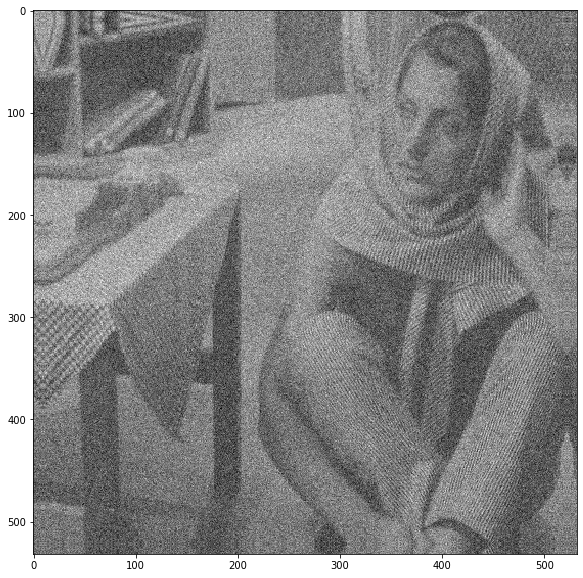

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(padded_noisy_image, cmap='gray')

In [5]:
def patch_matrix_windows(img, window_shape, step):
    patches = view_as_windows(img, window_shape, step=step)
    return patches, patches.shape

def generate_Q(P,vr):
    trunc = []
    weights = []
    for i in range(P.shape[0]):
        M = P[i].T
        rnk = np.linalg.matrix_rank(M)
        U,S,V = np.linalg.svd(M)
        k = 0
        cumsun = 0
        while vr >= cumsun+S[-(k+1)]**2:
            k+=1
            cumsun+=S[-k]**2
        rk = len(S)-k
        wj = max(1/(L+1),1-rk/(L+1))
        Qj = U[:,:rk]@np.diag(S[:rk])@V[:rk,]
        trunc.append(Qj)
        # print(rk)
        weights.append(wj)
    return np.array(trunc),np.array(weights)

def clear_patches(D,trunc):
    denoised_patches = []
    for i in range(D.shape[0]):
        inds, cols = np.where(D==i)
        estimates = trunc[inds,:,cols]
        pred = np.apply_along_axis(np.mean,0,estimates)
        denoised_patches.append(pred)
    return np.array(denoised_patches)


def weighted_pixel(i,j,start_inds,padded_noisy_image,
                   noisy_patches_shape,denoised_patches,weights,
                  step,m):
    mx = max(start_inds)
    if i>=mx+m or j>=mx+m: return padded_noisy_image[i,j]

    rows = start_inds[(i-start_inds<m) & (i-start_inds>=0)]
    cols = start_inds[(j-start_inds<m) & (j-start_inds>=0)]

    sm = 0
    W = 0
    for row in rows:
        for col in cols:
            row_adj =int(row/step)
            col_adj = int(col/step)

            ind_adj = noisy_patches_shape[0]*row_adj+col_adj

            patch = denoised_patches[ind_adj]

            ind = (i-row) + (j-col)*m

            sm+=patch[ind]*weights[ind_adj]
            W+=weights[ind_adj]
    return sm/W

def recover_image(noisy_image,start_inds,padded_noisy_image,
                   noisy_patches_shape,denoised_patches,weights,
                  step,m):
    
    res = np.zeros(padded_noisy_image.shape)
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            res[i,j] = weighted_pixel(i,j,start_inds,padded_noisy_image,
                   noisy_patches_shape,denoised_patches,weights,
                  step,m)
    
    return res

def create_D(noisy_patches_flatten,L):
    D = euclidean_distances(noisy_patches_flatten, noisy_patches_flatten)
    D=np.argsort(D)
    D = D[:,:L+1]
    return D

In [6]:
noisy_patches, noisy_patches_shape = patch_matrix_windows(padded_noisy_image, window_shape, step)
noisy_patches_flatten = noisy_patches.reshape(noisy_patches_shape[0],noisy_patches_shape[1],m**2,order='F')
noisy_patches_flatten = noisy_patches_flatten.reshape(noisy_patches_shape[0]*noisy_patches_shape[1],m**2)

In [7]:
D = create_D(noisy_patches_flatten,L)
P = noisy_patches_flatten[D,]

In [8]:
trunc,weights = generate_Q(P,vr)

In [9]:
denoised_patches = clear_patches(D,trunc)

In [10]:
start_inds = np.arange(0,(noisy_patches_shape[0]-1)*step,step)

In [11]:
res = recover_image(noisy_image,start_inds,padded_noisy_image,
                   noisy_patches_shape,denoised_patches,weights,
                  step,m)

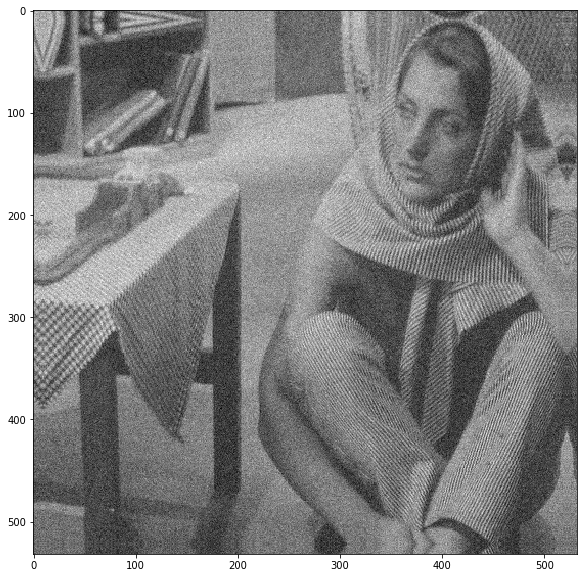

In [40]:
plt.figure(figsize=(20,10))
plt.imshow(res, cmap='gray')

In [23]:
gamma = 0.5
noisy_image = res+gamma*(padded_noisy_image-res)

In [26]:
padded_noisy_image = noisy_image
# padded_noisy_image = pad(noisy_image, pad_width=window_shape, mode='symmetric')

In [28]:
noisy_patches, noisy_patches_shape = patch_matrix_windows(padded_noisy_image, window_shape, step)
noisy_patches_flatten = noisy_patches.reshape(noisy_patches_shape[0],noisy_patches_shape[1],m**2,order='F')
noisy_patches_flatten = noisy_patches_flatten.reshape(noisy_patches_shape[0]*noisy_patches_shape[1],m**2)

In [29]:
D = create_D(noisy_patches_flatten,L)
P = noisy_patches_flatten[D,]

In [30]:
trunc,weights = generate_Q(P,vr)

In [31]:
denoised_patches = clear_patches(D,trunc)

In [32]:
start_inds = np.arange(0,(noisy_patches_shape[0]-1)*step,step)

In [33]:
res = recover_image(noisy_image,start_inds,padded_noisy_image,
                   noisy_patches_shape,denoised_patches,weights,
                  step,m)

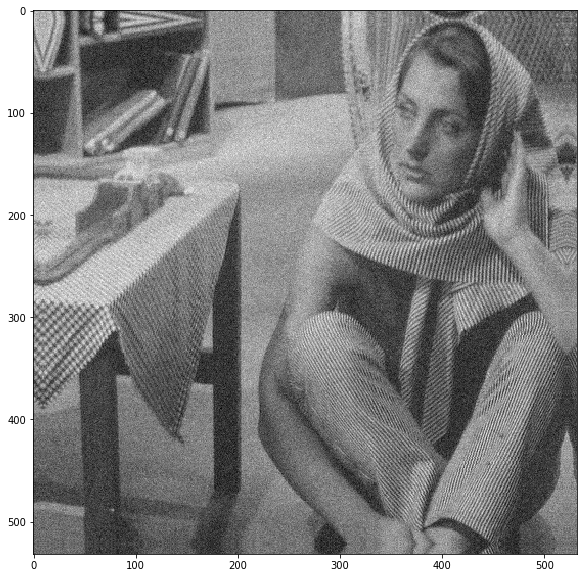

In [42]:
plt.figure(figsize=(20,10))
plt.imshow(res, cmap='gray')